In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierVAE
from alibi_detect.models.losses import elbo
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((32,32))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

path = "D:\\cybord\\img\\capsule\\*.*"
train = img_to_np(path)
train = train.astype('float32') / 255.
#test = test.astype('float32') / 255.

print(train.shape)

(239, 32, 32, 3)


In [17]:
latent_dim = 1024

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(4*4*128),
      Reshape(target_shape=(4, 4, 128)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])


# initialize outlier detector
od = OutlierVAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net,
                latent_dim = latent_dim)

adam = tf.keras.optimizers.Adam(lr=1e-4)

# train
od.fit(train, epochs=250, verbose=True,
       loss_fn=elbo,
       optimizer = adam)

decoder_net.summary()

4/4 [=] - 0s 32ms/step - loss: -6135.9158
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 64)        262208    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 3)         3075      
Total params: 2,889,027
Trainable params: 2,889,027
Non-trainable params: 0
_________________________________________________________________


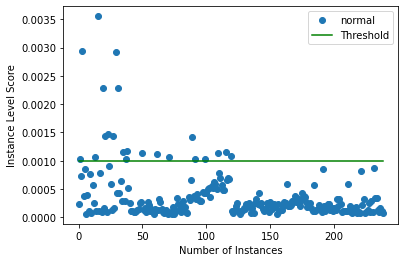

Counter({0: 217, 1: 22})

In [18]:
preds = od.predict(train, outlier_type='instance',
            return_instance_score=True)
target = np.zeros(train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

Counter(preds['data']['is_outlier'])

<Figure size 864x576 with 0 Axes>

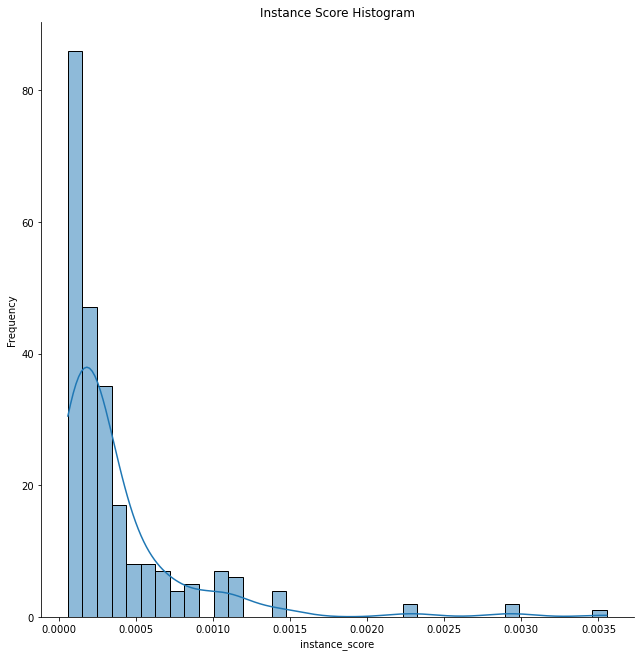

threshold: 0.001


In [19]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.displot(data=preds['data'], x='instance_score', kde=True, height=9)
plt.title('Instance Score Histogram')
plt.ylabel('Frequency')
plt.show()

thresh = od.threshold
print("threshold:", thresh)

In [20]:
print('99th percentile:', np.percentile(preds['data']['instance_score'], 90))

99th percentile: 0.0008545514079742136


In [21]:
fpaths = glob.glob('img/*.*')
for fname in fpaths:
    os.remove(fname)

for i, fpath in enumerate(glob.glob(path)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        dest = "img/" + os.path.basename(fpath)
        copyfile(source, dest)

In [22]:
filenames = [os.path.basename(x) for x in glob.glob(path)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)

df[df['is_outlier'] == 1]

,Filename,instance_score,is_outlier
1,000_.png,0.001034,1
3,001_.png,0.002935,1
13,006_.png,0.001072,1
15,007_.png,0.003553,1
19,009_.png,0.002282,1
21,010_.png,0.001440,1
23,011_.png,0.001470,1
27,013_.png,0.001432,1
29,014_.png,0.002927,1
31,015_.png,0.002288,1


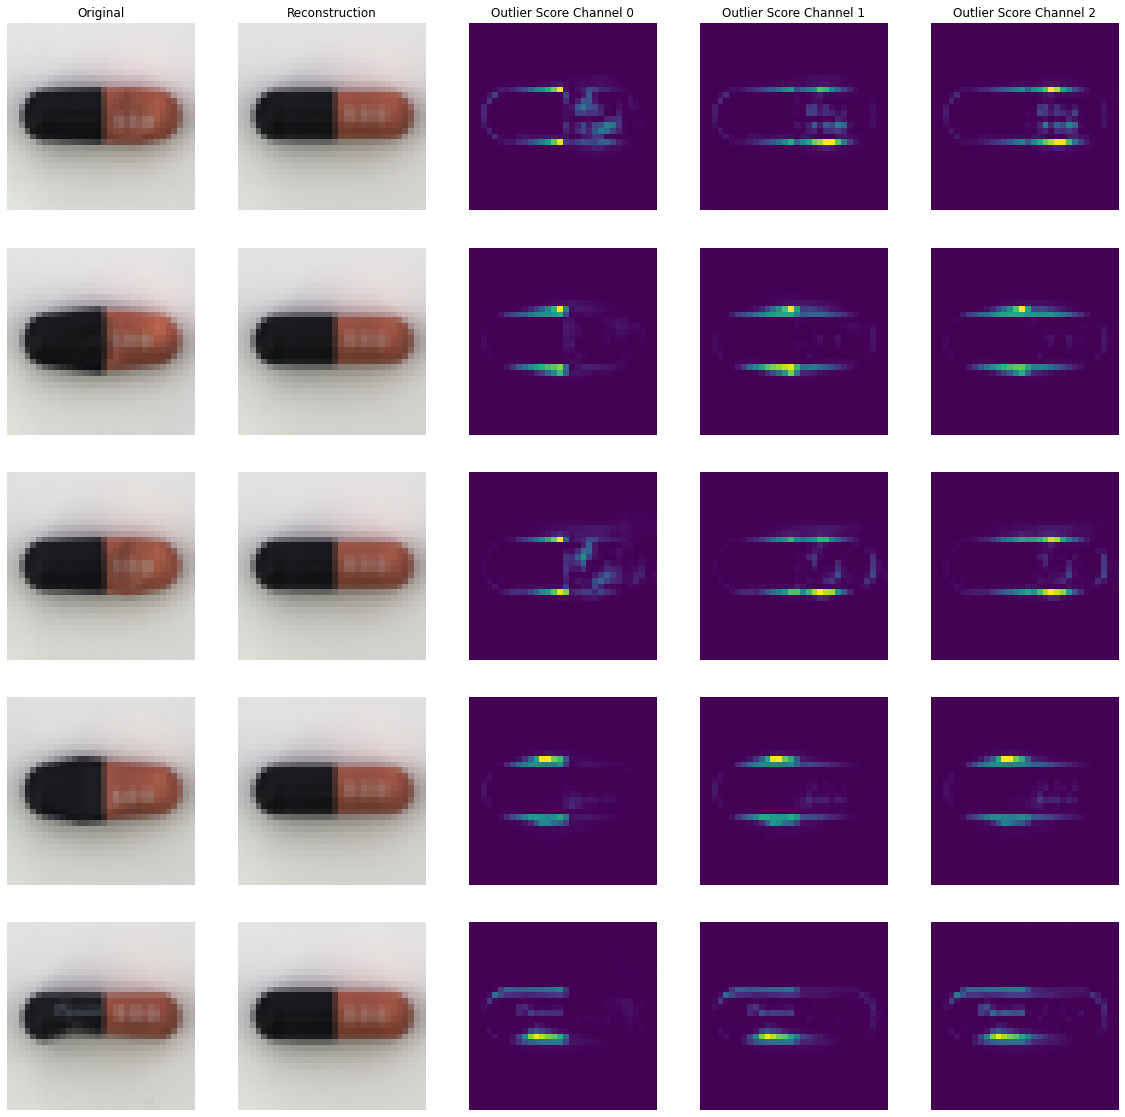

In [23]:
recon = od.vae(train).numpy()

plot_feature_outlier_image(preds, train, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(20,20))